* input : df_kernel.csv

* C'est un jeu de données avec un pre-processing du kernel Kaggle
* on utilise un pipeline pour équilibrer les classes des cibles
* modélisation
* calcul de la fonction de coût des modèles

# Introduction

## Problématique

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

## Données

* 10 fichiers CSV
* Vous aurez sûrement besoin de joindre les différentes tables entre elles.

## Votre mission

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

Spécifications du dashboard
Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :

Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

## Imports et paramétrage

In [1]:
#Importation des librairies utiles pour le projet :

#built in
import statistics
import os, sys, time, random
from collections import Counter

#data
import pandas as pd
import numpy as np

#stats
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

#viz
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from PIL import Image

# modelisation
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import TruncatedSVD 
from sklearn import decomposition
#from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline 

# models

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import cluster
import scipy.cluster.hierarchy as shc
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics.cluster import adjusted_rand_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
import sklearn.metrics
#from functions import *

import shap
import pickle

C:\Users\ndergham\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.set_option("display.max_rows", None)

In [3]:
#Importation des jeux de données utiles pour le projet :

df1 = pd.read_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/df_kernel.csv")
df1 = df1.sample(frac = 0.1)
df1 = df1.dropna()

# Comprendre la forme et la structure des données

## Jeux de données

On va regarder rapidement les informations contenues dans les différents jeux de données pour savoir lesquelles sont intéressantes 

In [4]:
df1.head()

,TARGET,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_ID_PUBLISH.1,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,AMT_GOODS_PRICE,AMT_CREDIT,AMT_ANNUITY,ANNUITY_INCOME_PERC,REGION_POPULATION_RELATIVE
65615,0.0,176102,0.038217,0.786267,0.706093,0.639457,-14241,-5347,-5347,-3179.0,-1009.0,0.070852,922500.0,1002870.0,38326.5,0.170340,0.046220
210752,0.0,344230,0.050000,0.716570,0.627709,0.497190,-10346,-1245,-1245,-3198.0,-615.0,0.059443,180000.0,180000.0,9000.0,0.086957,0.022800
242184,0.0,380386,0.091700,0.408359,0.404470,0.187944,-8121,-801,-801,-7334.0,-572.0,0.070435,135000.0,135000.0,12379.5,0.110040,0.010006
158049,0.0,283219,0.048840,0.362277,0.729817,0.240221,-10773,-3457,-3457,-4849.0,-3115.0,0.289149,450000.0,640080.0,31261.5,0.173675,0.035792
250273,0.0,389590,0.051060,0.633032,0.620867,0.546604,-13170,-4523,-4523,-7133.0,-107.0,0.008125,225000.0,225000.0,11488.5,0.127650,0.019689


In [5]:
df1.shape

(9867, 17)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9867 entries, 65615 to 113971
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TARGET                      9867 non-null   float64
 1   SK_ID_CURR                  9867 non-null   int64  
 2   PAYMENT_RATE                9867 non-null   float64
 3   EXT_SOURCE_3                9867 non-null   float64
 4   EXT_SOURCE_2                9867 non-null   float64
 5   EXT_SOURCE_1                9867 non-null   float64
 6   DAYS_BIRTH                  9867 non-null   int64  
 7   DAYS_ID_PUBLISH             9867 non-null   int64  
 8   DAYS_ID_PUBLISH.1           9867 non-null   int64  
 9   DAYS_REGISTRATION           9867 non-null   float64
 10  DAYS_EMPLOYED               9867 non-null   float64
 11  DAYS_EMPLOYED_PERC          9867 non-null   float64
 12  AMT_GOODS_PRICE             9867 non-null   float64
 13  AMT_CREDIT                 

In [7]:
df1.dtypes

TARGET                        float64
SK_ID_CURR                      int64
PAYMENT_RATE                  float64
EXT_SOURCE_3                  float64
EXT_SOURCE_2                  float64
EXT_SOURCE_1                  float64
DAYS_BIRTH                      int64
DAYS_ID_PUBLISH                 int64
DAYS_ID_PUBLISH.1               int64
DAYS_REGISTRATION             float64
DAYS_EMPLOYED                 float64
DAYS_EMPLOYED_PERC            float64
AMT_GOODS_PRICE               float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
ANNUITY_INCOME_PERC           float64
REGION_POPULATION_RELATIVE    float64
dtype: object

In [8]:
df1.dtypes.value_counts()

float64    13
int64       4
dtype: int64

# Modélisation

## Définition cible et variables

In [9]:
cols = ["PAYMENT_RATE", "EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1", "DAYS_BIRTH",
           "DAYS_ID_PUBLISH", "DAYS_ID_PUBLISH.1", "DAYS_REGISTRATION", "DAYS_EMPLOYED", "DAYS_EMPLOYED_PERC",
           "AMT_GOODS_PRICE", "AMT_CREDIT", "AMT_ANNUITY", "ANNUITY_INCOME_PERC", "REGION_POPULATION_RELATIVE"]
df = df1[cols]
df.head()

,PAYMENT_RATE,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_ID_PUBLISH.1,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,AMT_GOODS_PRICE,AMT_CREDIT,AMT_ANNUITY,ANNUITY_INCOME_PERC,REGION_POPULATION_RELATIVE
65615,0.038217,0.786267,0.706093,0.639457,-14241,-5347,-5347,-3179.0,-1009.0,0.070852,922500.0,1002870.0,38326.5,0.170340,0.046220
210752,0.050000,0.716570,0.627709,0.497190,-10346,-1245,-1245,-3198.0,-615.0,0.059443,180000.0,180000.0,9000.0,0.086957,0.022800
242184,0.091700,0.408359,0.404470,0.187944,-8121,-801,-801,-7334.0,-572.0,0.070435,135000.0,135000.0,12379.5,0.110040,0.010006
158049,0.048840,0.362277,0.729817,0.240221,-10773,-3457,-3457,-4849.0,-3115.0,0.289149,450000.0,640080.0,31261.5,0.173675,0.035792
250273,0.051060,0.633032,0.620867,0.546604,-13170,-4523,-4523,-7133.0,-107.0,0.008125,225000.0,225000.0,11488.5,0.127650,0.019689


In [10]:
cols = ["SK_ID_CURR", "PAYMENT_RATE", "EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1", "DAYS_BIRTH",
           "DAYS_ID_PUBLISH", "DAYS_ID_PUBLISH.1", "DAYS_REGISTRATION", "DAYS_EMPLOYED", "DAYS_EMPLOYED_PERC",
           "AMT_GOODS_PRICE", "AMT_CREDIT", "AMT_ANNUITY", "ANNUITY_INCOME_PERC", "REGION_POPULATION_RELATIVE"]
df2 = df1[cols]
df2.head()

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_ID_PUBLISH.1,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,AMT_GOODS_PRICE,AMT_CREDIT,AMT_ANNUITY,ANNUITY_INCOME_PERC,REGION_POPULATION_RELATIVE
65615,176102,0.038217,0.786267,0.706093,0.639457,-14241,-5347,-5347,-3179.0,-1009.0,0.070852,922500.0,1002870.0,38326.5,0.170340,0.046220
210752,344230,0.050000,0.716570,0.627709,0.497190,-10346,-1245,-1245,-3198.0,-615.0,0.059443,180000.0,180000.0,9000.0,0.086957,0.022800
242184,380386,0.091700,0.408359,0.404470,0.187944,-8121,-801,-801,-7334.0,-572.0,0.070435,135000.0,135000.0,12379.5,0.110040,0.010006
158049,283219,0.048840,0.362277,0.729817,0.240221,-10773,-3457,-3457,-4849.0,-3115.0,0.289149,450000.0,640080.0,31261.5,0.173675,0.035792
250273,389590,0.051060,0.633032,0.620867,0.546604,-13170,-4523,-4523,-7133.0,-107.0,0.008125,225000.0,225000.0,11488.5,0.127650,0.019689


In [11]:
df2.to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/df_ok_flask_final.csv", index = False)

In [12]:
y = df1.TARGET

In [13]:
y.value_counts(normalize = True)

0.0    0.924293
1.0    0.075707
Name: TARGET, dtype: float64

In [14]:
X_train_id, X_test_id, y_train, y_test = train_test_split(df2, y, test_size=0.2)

In [15]:
X_test_id = X_test_id.reset_index(drop=True)

In [16]:
X_test_id.head()

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_ID_PUBLISH.1,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,AMT_GOODS_PRICE,AMT_CREDIT,AMT_ANNUITY,ANNUITY_INCOME_PERC,REGION_POPULATION_RELATIVE
0,401257,0.051255,0.000527,0.272595,0.228684,-14698,-734,-734,-3460.0,-2467.0,0.167846,540000.0,668304.0,34254.0,0.362476,0.009630
1,233848,0.079471,0.221335,0.707479,0.626440,-13193,-4445,-4445,-5901.0,-1537.0,0.116501,229500.0,277969.5,22090.5,0.070129,0.011703
2,296177,0.029352,0.694093,0.702810,0.431681,-15999,-4083,-4083,-8441.0,-2273.0,0.142071,990000.0,1133748.0,33277.5,0.211286,0.025164
3,178381,0.042367,0.689479,0.709710,0.403927,-12225,-4027,-4027,-1055.0,-313.0,0.025603,675000.0,755190.0,31995.0,0.142200,0.019101
4,420824,0.049600,0.590233,0.268461,0.322715,-15227,-4659,-4659,-4135.0,-1132.0,0.074342,135000.0,135000.0,6696.0,0.037200,0.014520


In [17]:
X_train = X_train_id.drop(['SK_ID_CURR'], axis=1)

In [18]:
X_test = X_test_id.drop(['SK_ID_CURR'], axis=1)

# Modélisation

On va implémenter plusieurs modèles de classification et comparer leur performance pour connaitre la meilleur configuration.

En plus des différents modèles, on va comparer :

- l'usage ou non d'un standard scaler
- l'usage ou non d'un reducteur dimensionnel (PCA, LDA, TruncatedSVD)

On créé un fonction pour afficher les résultats de la grid search triés par **mean_test_score** du plus grand au plus petit.

Le **mean_test_score** est la moyenne des score de test des modèles prédictifs entrainés et testé sur chaque "fold" de la validation croisée.

In [19]:
def resultize(grid, model = "", data ="") : 
    """ """
    
    res = pd.DataFrame(grid.cv_results_)
    res["model"] = model
    cols = [i for i in res.columns if "split" not in i  ]
    
    res
    
    
    return res[cols].sort_values("rank_test_score", ascending=True)

In [20]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Grid search

In [21]:
param_grid = {
    
    "sampler": [RandomUnderSampler(), "passthrough"],
    "scaler": [StandardScaler(), "passthrough"],
    "estimator": [DummyClassifier()],
    
}

## Pipeline avec IMB learn

In [22]:
pipe = Pipeline([
    ('sampler', "passthrough"), 
    ("scaler" , "passthrough"),
    ('estimator', DummyClassifier())
])


## DummyClassifier

In [23]:
dummy = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
dummy.fit(X_train, y_train)
res = resultize(dummy, model = "dummy")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
0,0.020335,0.007195,0.004902,0.007047,DummyClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': DummyClassifier(), 'sampler': Ra...",0.5,0.0,1,dummy
1,0.010937,0.007160,0.003125,0.006250,DummyClassifier(),RandomUnderSampler(),passthrough,"{'estimator': DummyClassifier(), 'sampler': Ra...",0.5,0.0,1,dummy
2,0.012498,0.006249,0.004689,0.007162,DummyClassifier(),passthrough,StandardScaler(),"{'estimator': DummyClassifier(), 'sampler': 'p...",0.5,0.0,1,dummy
3,0.001563,0.004690,0.004687,0.007159,DummyClassifier(),passthrough,passthrough,"{'estimator': DummyClassifier(), 'sampler': 'p...",0.5,0.0,1,dummy


### Indicateurs

In [24]:
y_pred_dummy = dummy.predict(X_test)

In [25]:
a0 = confusion_matrix(y_test, y_pred_dummy)
a0

array([[1808,    0],
       [ 166,    0]], dtype=int64)

In [26]:
b0 = accuracy_score(y_test, y_pred_dummy)
b0

0.9159067882472138

In [27]:
c0 = f1_score(y_test, y_pred_dummy)
c0

0.0

In [28]:
d0 = recall_score(y_test, y_pred_dummy)
d0

0.0

In [29]:
e0 = precision_score(y_test, y_pred_dummy)
e0

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


0.0

In [30]:
f0 = roc_auc_score(y_test, y_pred_dummy)
f0

0.5

## Random Forest

In [31]:
param_grid = {
    
    "sampler": [RandomUnderSampler(), "passthrough"],
    "scaler": [StandardScaler(), "passthrough"],
    "estimator": [RandomForestClassifier(min_samples_split = 5, min_samples_leaf = 1, max_depth = 20, n_estimators = 500)],
    
}


In [32]:
pipe = Pipeline([
    ('sampler', "passthrough"), 
    ("scaler" , "passthrough"),
    ('estimator', RandomForestClassifier(min_samples_split = 5, min_samples_leaf = 1, max_depth = 20, n_estimators = 500))
])

In [33]:
R_F = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
R_F.fit(X_train, y_train)
res = resultize(R_F, model = "Random Forest")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
0,2.567333,0.134511,0.167434,0.007330,"RandomForestClassifier(max_depth=20, min_sampl...",RandomUnderSampler(),StandardScaler(),{'estimator': RandomForestClassifier(max_depth...,0.717782,0.038091,1,Random Forest
1,2.550223,0.116270,0.186229,0.025867,"RandomForestClassifier(max_depth=20, min_sampl...",RandomUnderSampler(),passthrough,{'estimator': RandomForestClassifier(max_depth...,0.715824,0.038727,2,Random Forest
3,14.437874,2.446732,0.158851,0.044938,"RandomForestClassifier(max_depth=20, min_sampl...",passthrough,passthrough,{'estimator': RandomForestClassifier(max_depth...,0.705082,0.040548,3,Random Forest
2,17.090968,0.617812,0.208141,0.012374,"RandomForestClassifier(max_depth=20, min_sampl...",passthrough,StandardScaler(),{'estimator': RandomForestClassifier(max_depth...,0.702609,0.040240,4,Random Forest


In [34]:
y_pred_rf = R_F.predict(X_test)

In [35]:
a1 = confusion_matrix(y_test, y_pred_rf)
a1

array([[1187,  621],
       [  52,  114]], dtype=int64)

In [36]:
b1 = accuracy_score(y_test, y_pred_rf)
b1

0.6590678824721378

In [37]:
c1 = f1_score(y_test, y_pred_rf)
c1

0.2530521642619312

In [38]:
d1 = recall_score(y_test, y_pred_rf)
d1

0.6867469879518072

In [39]:
e1 = precision_score(y_test, y_pred_rf)
e1

0.15510204081632653

In [40]:
f1 = roc_auc_score(y_test, y_pred_rf)
f1

0.6716367683121869

## K-NN

In [41]:
param_grid = {
    
    "sampler": [RandomUnderSampler(), "passthrough"],
    "scaler": [StandardScaler(), "passthrough"],
    "estimator": [neighbors.KNeighborsClassifier(n_neighbors=3)],
    
}


In [42]:
pipe = Pipeline([
    ('sampler', "passthrough"), 
    ("scaler" , "passthrough"),
    ('estimator', neighbors.KNeighborsClassifier(n_neighbors=3))
])

In [43]:
K_NN = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
K_NN.fit(X_train, y_train)
res = resultize(K_NN, model = "K-NN")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
0,0.025922,0.005825,0.060324,0.011126,KNeighborsClassifier(n_neighbors=3),RandomUnderSampler(),StandardScaler(),{'estimator': KNeighborsClassifier(n_neighbors...,0.630974,0.025777,1,K-NN
2,0.064482,0.007258,0.256970,0.034285,KNeighborsClassifier(n_neighbors=3),passthrough,StandardScaler(),{'estimator': KNeighborsClassifier(n_neighbors...,0.571114,0.018565,2,K-NN
1,0.030199,0.010214,0.012946,0.002689,KNeighborsClassifier(n_neighbors=3),RandomUnderSampler(),passthrough,{'estimator': KNeighborsClassifier(n_neighbors...,0.528365,0.039252,3,K-NN
3,0.074327,0.009848,0.026802,0.006911,KNeighborsClassifier(n_neighbors=3),passthrough,passthrough,{'estimator': KNeighborsClassifier(n_neighbors...,0.521583,0.021923,4,K-NN


In [44]:
y_pred_knn = K_NN.predict(X_test)

In [45]:
a2 = confusion_matrix(y_test, y_pred_knn)
a2

array([[1076,  732],
       [  57,  109]], dtype=int64)

In [46]:
b2 = accuracy_score(y_test, y_pred_knn)
b2

0.6003039513677811

In [47]:
c2 = f1_score(y_test, y_pred_knn)
c2

0.21648460774577952

In [48]:
d2 =recall_score(y_test, y_pred_knn)
d2

0.6566265060240963

In [49]:
e2 = precision_score(y_test, y_pred_knn)
e2

0.12960760998810938

In [50]:
f2 = roc_auc_score(y_test, y_pred_knn)
f2

0.6258796246934641

## regression logistique

In [51]:
param_grid = {
    
    "sampler": [RandomUnderSampler(), "passthrough"],
    "scaler": [StandardScaler(), "passthrough"],
    "estimator": [LogisticRegression()],
    
}

In [52]:
pipe = Pipeline([
    ('sampler', "passthrough"), 
    ("scaler" , "passthrough"),
    ('estimator', LogisticRegression())
])

In [53]:
R_L = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
R_L.fit(X_train, y_train)
res = resultize(R_L, model = "Regression logistique")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
2,0.058101,0.014962,0.005700,0.000638,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.742888,0.038915,1,Regression logistique
0,0.048086,0.009759,0.005300,0.000781,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.738433,0.042013,2,Regression logistique
1,0.053553,0.007488,0.007619,0.007390,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.607942,0.048181,3,Regression logistique
3,0.143664,0.023456,0.005227,0.000870,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.599808,0.041668,4,Regression logistique


In [54]:
y_pred_rl = R_L.predict(X_test)

In [55]:
a3 = confusion_matrix(y_test, y_pred_rl)
a3

array([[1807,    1],
       [ 164,    2]], dtype=int64)

In [56]:
b3 = accuracy_score(y_test, y_pred_rl)
b3

0.9164133738601824

In [57]:
c3 = f1_score(y_test, y_pred_rl)
c3

0.023668639053254437

In [58]:
d3 = recall_score(y_test, y_pred_rl)
d3

0.012048192771084338

In [59]:
e3 = precision_score(y_test, y_pred_rl)
e3

0.6666666666666666

In [60]:
f3 = roc_auc_score(y_test, y_pred_rl)
f3

0.5057475477129757

# Récapitulatif et conclusions

In [66]:
resultats = pd.DataFrame({
                        'Dummy': [a0, b0, c0, d0, e0, f0], 
                          'Random Forest': [a1, b1, c1, d1, e1, f1],
                         'K-NN': [a2, b2, c2, d2, e2, f2],
                         'Logistic regression': [a3, b3, c3, d3, e3, f3]},
                         index = ['Matrice de confusion', 'Accuracy', "F1", "Recall", "Precision", "ROC AUC"])

In [67]:
resultats

,Dummy,Random Forest,K-NN,Logistic regression
Matrice de confusion,"[[1808, 0], [166, 0]]","[[1187, 621], [52, 114]]","[[1076, 732], [57, 109]]","[[1807, 1], [164, 2]]"
Accuracy,0.915907,0.659068,0.600304,0.916413
F1,0.0,0.253052,0.216485,0.023669
Recall,0.0,0.686747,0.656627,0.012048
Precision,0.0,0.155102,0.129608,0.666667
ROC AUC,0.5,0.671637,0.62588,0.505748


Les resultats sont meilleurs avec le modèle random forest

# Fonction de décision

In [68]:
def fonction_decision (X):
    
    # extract amount credit
    #X["profit"] = X["AMT_CREDIT"] * rate
    
    
    # compute profit and lost 
   
    if X["pred"] == 1 :
         return 0
    elif X["y_true"] == 0 and X["pred"] == 0:
         return X["profit"]

    return -X["AMT_CREDIT"]

## DummyClasifier

In [69]:
X_dummy = pd.DataFrame(y_pred_dummy, columns = ["pred"])

In [70]:
X_dummy["y_true"] = y_test.reset_index(drop = True)

In [71]:
X_dummy["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [72]:
X_dummy["profit"] = X_test["AMT_CREDIT"] * 0.04
X_dummy.head(10)

,pred,y_true,AMT_CREDIT,profit
0,0.0,1.0,668304.0,26732.16
1,0.0,1.0,277969.5,11118.78
2,0.0,0.0,1133748.0,45349.92
3,0.0,0.0,755190.0,30207.60
4,0.0,0.0,135000.0,5400.00
5,0.0,0.0,302076.0,12083.04
6,0.0,0.0,331632.0,13265.28
7,0.0,0.0,495000.0,19800.00
8,0.0,0.0,1921797.0,76871.88
9,0.0,0.0,573408.0,22936.32


In [73]:
PNL = []

for i in X_dummy.index :
    result = fonction_decision(X_dummy.loc[i])
    PNL.append(result)

In [74]:
PNL

[-668304.0,
 -277969.5,
 45349.92,
 30207.600000000002,
 5400.0,
 12083.04,
 13265.28,
 19800.0,
 76871.88,
 22936.32,
 7200.0,
 11851.2,
 51534.0,
 6300.0,
 12600.0,
 20851.2,
 14337.720000000001,
 40276.8,
 18000.0,
 18360.0,
 18950.4,
 19800.0,
 14400.0,
 15840.0,
 14081.76,
 29138.4,
 28800.0,
 5212.8,
 -284400.0,
 20476.8,
 9891.0,
 49008.96,
 14400.0,
 3056.4,
 43128.0,
 31080.96,
 72929.7,
 5214.6,
 30600.0,
 40276.8,
 12252.24,
 -728460.0,
 10800.0,
 11554.92,
 5400.0,
 14400.0,
 41702.4,
 13317.84,
 5501.52,
 32346.0,
 13500.0,
 50256.0,
 -508495.5,
 18000.0,
 30409.02,
 27000.0,
 19900.8,
 59723.46,
 49898.880000000005,
 30600.0,
 15105.960000000001,
 -490536.0,
 10051.2,
 39326.4,
 70484.40000000001,
 10800.0,
 12600.0,
 37923.840000000004,
 12426.84,
 18000.0,
 10997.64,
 20851.2,
 -1024740.0,
 57136.32,
 7053.12,
 9360.0,
 45000.0,
 45000.0,
 63000.0,
 34200.0,
 21801.600000000002,
 53389.26,
 14221.44,
 27180.0,
 20497.86,
 33415.2,
 31500.0,
 25021.440000000002,
 11990.8

In [75]:
cout_dummy = sum(PNL)
cout_dummy

-45676208.519999966

## Random Forest

In [76]:
X_rf = pd.DataFrame(y_pred_rf, columns = ["pred"])

In [77]:
X_rf["y_true"] = y_test.reset_index(drop = True)

In [78]:
X_rf["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [79]:
X_rf["profit"] = X_test["AMT_CREDIT"] * 0.04
X_rf.head()

,pred,y_true,AMT_CREDIT,profit
0,1.0,1.0,668304.0,26732.16
1,1.0,1.0,277969.5,11118.78
2,0.0,0.0,1133748.0,45349.92
3,0.0,0.0,755190.0,30207.60
4,0.0,0.0,135000.0,5400.00


In [80]:
PNL = []

for i in X_rf.index :
    result = fonction_decision(X_rf.loc[i])
    PNL.append(result)

In [81]:
PNL

[0,
 0,
 45349.92,
 30207.600000000002,
 5400.0,
 0,
 13265.28,
 0,
 76871.88,
 22936.32,
 0,
 0,
 51534.0,
 0,
 12600.0,
 20851.2,
 14337.720000000001,
 40276.8,
 0,
 18360.0,
 0,
 19800.0,
 14400.0,
 0,
 14081.76,
 0,
 28800.0,
 0,
 0,
 0,
 0,
 49008.96,
 14400.0,
 0,
 43128.0,
 31080.96,
 0,
 5214.6,
 30600.0,
 40276.8,
 0,
 0,
 10800.0,
 11554.92,
 5400.0,
 14400.0,
 41702.4,
 13317.84,
 5501.52,
 32346.0,
 13500.0,
 50256.0,
 -508495.5,
 0,
 30409.02,
 27000.0,
 0,
 59723.46,
 0,
 0,
 15105.960000000001,
 0,
 0,
 39326.4,
 70484.40000000001,
 10800.0,
 12600.0,
 37923.840000000004,
 12426.84,
 18000.0,
 10997.64,
 0,
 -1024740.0,
 57136.32,
 0,
 0,
 0,
 45000.0,
 0,
 0,
 0,
 53389.26,
 0,
 27180.0,
 20497.86,
 33415.2,
 31500.0,
 0,
 11990.880000000001,
 21801.600000000002,
 0,
 36000.0,
 0,
 0,
 0,
 -284400.0,
 72000.0,
 0,
 10800.0,
 7200.0,
 0,
 19900.8,
 12564.0,
 21569.22,
 23702.4,
 0,
 0,
 61019.28,
 19620.0,
 18000.0,
 27180.0,
 0,
 0,
 51534.0,
 43128.0,
 43840.8,
 0,
 42

In [82]:
cout_RF = sum(PNL)
cout_RF

-445344.65999999834

# Récapitulatif des coûts des modèles


In [83]:
resultats_modeles = pd.DataFrame({
                        'Dummy': [cout_dummy], 
                          'Random Forest': [cout_RF]},
                         index = ["Profit"])
resultats_modeles

,Dummy,Random Forest
Profit,-45676208.52,-445344.66


# Shap

In [84]:
RF = RandomForestClassifier(max_depth=2, random_state=0)
RF.fit(X_test, y_test)

RandomForestClassifier(max_depth=2, random_state=0)

In [85]:
with open("RF.pk","wb") as f:
    pickle.dump(RF, f)

RF

with open("RF.pk","rb") as f:
    model = pickle.load(f)

model

RandomForestClassifier(max_depth=2, random_state=0)

In [86]:
preds = RF.predict(X_test)

## Shap

In [87]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(RF)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

In [88]:
shap_values

[array([[ 1.18971394e-03, -8.83818973e-02,  6.40845891e-04, ...,
          1.45617976e-04, -8.99837451e-04, -3.90267958e-03],
        [-2.01087623e-03, -9.16700726e-03,  7.55247065e-03, ...,
          1.60393389e-04,  5.15888786e-04, -1.50529421e-03],
        [ 2.09218451e-03,  5.18728395e-03,  6.37092706e-03, ...,
         -8.70612280e-06, -3.21570800e-04,  7.11550825e-04],
        ...,
        [ 9.64232436e-04,  5.08498572e-03,  7.12402055e-03, ...,
          6.06929091e-06, -3.21570800e-04,  2.60668016e-03],
        [-2.44333792e-03,  4.56715599e-03,  3.01696953e-03, ...,
         -1.77896010e-04, -4.20777149e-04,  3.13768913e-04],
        [ 7.16748260e-04, -8.62528825e-03,  4.68668164e-03, ...,
          1.25274443e-04, -1.90173972e-04,  4.00576632e-04]]),
 array([[-1.18971394e-03,  8.83818973e-02, -6.40845891e-04, ...,
         -1.45617976e-04,  8.99837451e-04,  3.90267958e-03],
        [ 2.01087623e-03,  9.16700726e-03, -7.55247065e-03, ...,
         -1.60393389e-04, -5.15888786e

In [89]:
shap_false = shap_values[0]

In [90]:
shap_true= shap_values[1]

In [91]:
df_shap_false = pd.DataFrame(shap_false, columns = X_test.columns)
df_shap_true = pd.DataFrame(shap_true, columns = X_test.columns)

In [92]:
df_shap_false.shape

(1974, 15)

In [93]:
X_test.shape

(1974, 15)

In [94]:
df_shap_false["SK_ID_CURR"] = X_test_id["SK_ID_CURR"]
df_shap_true["SK_ID_CURR"] = X_test_id["SK_ID_CURR"]

In [95]:
df_shap_false.to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/shap_false_imbl.csv", index = True)

In [96]:
df_shap_true.to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/shap_true_imbl.csv", index = True)

In [97]:
df_shap_false.sum().to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/explainer_false_imbl.csv", index = True)

In [98]:
df_shap_true.sum().to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/explainer_true_imbl.csv", index = True)

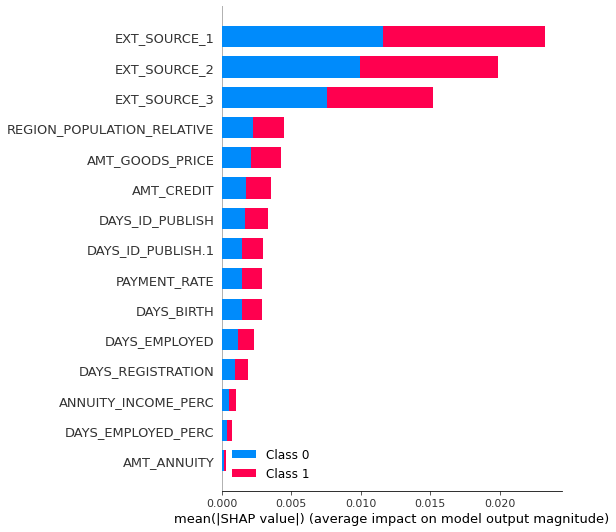

In [99]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

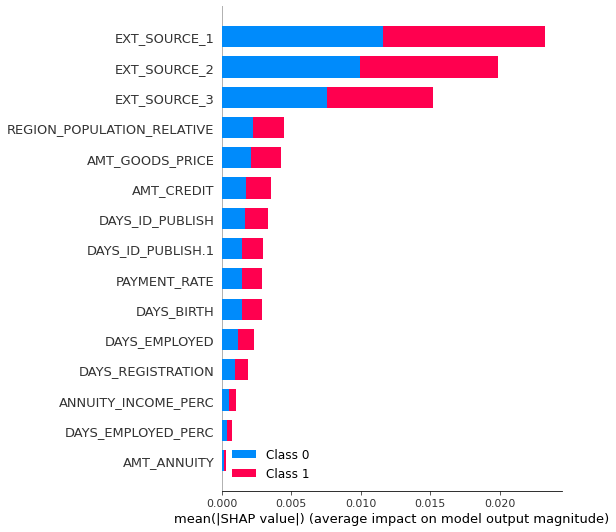

In [100]:
shap.summary_plot(shap_values, X_test)

In [101]:
row_to_show = 5

data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

RF.predict_proba(data_for_prediction_array)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0.84310347, 0.15689653]])

In [103]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(RF.predict_proba, X_train)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction, matplotlib=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Using 7893 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


MemoryError: Unable to allocate 1.83 GiB for an array with shape (2078, 118395) and data type float64

# Score

In [ ]:
preds_proba = RF.predict_proba(X_test)

In [ ]:
preds_proba

In [ ]:
df_preds_proba = pd.DataFrame(preds_proba, columns = ["0", "1"])
df_preds_proba

In [ ]:
 df_preds_proba["SK_ID_CURR"] = X_test_id["SK_ID_CURR"]

In [ ]:
df_preds_proba

In [ ]:
df_preds_proba.to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/proba_imb.csv", index = False)